# One-way ANOVA: 
## UFC Fighter's stance vs knockout percentage 

In [1]:
#Setting theme
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
# For data cleaning/feature engineering
import numpy as np
import pandas as pd

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

#For statistical tests
import pingouin as pg
import statsmodels as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import levene
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults
from statsmodels.stats.diagnostic import kstest_normal
from scipy.stats import shapiro

In [3]:
sns.set(style = 'darkgrid', palette = 'bright')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
df = pd.read_csv('fighter_stance_tko.csv') 

In [147]:
df.drop('Unnamed: 0',axis=1, inplace=True)

In [148]:
display(df.memory_usage(), df.memory_usage().sum())

Index             128
name             5056
last_name        5056
stance           5056
wins             5056
losses           5056
SLpM             5056
fights           5056
tko_win_ratio    5056
dtype: int64

40576

In [149]:
def reduce_memory_usage(data, pct_threshold=0.4): 
    '''Can be reapplied after 
    outlier handling and scaling'''
    
    start_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage before: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != 'object':
            c_min = data[col].min()
            c_max = data[col].max()
            if 'int' in str(col_type): 
                if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    data[col] = data[col].astype(np.uint8)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    data[col] = data[col].astype(np.uint16)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    data[col] = data[col].astype(np.uint32)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    data[col] = data[col].astype(np.uint64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)
        
        elif col_type=='object':
            if data[col].nunique() / data[col].shape[0] < pct_threshold:  
                data[col] = data[col].astype('category') 
            else:
                continue

    end_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage now : {:.2f} MB'.format(end_mem))
    print('Memory usage decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [150]:
reduce_mem_usage(df)

Memory usage before: 0.04 MB
Memory usage now : 0.01 MB
Memory usage decreased by 61.8%


,name,last_name,stance,wins,losses,SLpM,fights,tko_win_ratio
0,David,Abbott,Switch,10,15,1.349609,25,0.620117
1,Shamil,Abdurakhimov,Orthodox,20,6,2.529297,26,0.399902
2,Israel,Adesanya,Switch,22,1,3.839844,23,0.360107
3,Omari,Akhmedov,Orthodox,21,6,2.970703,27,0.219971
4,Yoshihiro,Akiyama,Orthodox,14,6,3.099609,20,0.360107
...,...,...,...,...,...,...,...,...
627,Hidehiko,Yoshida,Orthodox,6,8,1.049805,14,0.000000
628,Sodiq,Yusuff,Orthodox,11,2,5.429688,13,0.399902
629,Elizeu,Zaleski dos Santos,Orthodox,23,7,4.648438,30,0.330078
630,Marius,Zaromskis,Orthodox,20,9,5.019531,29,0.669922


In [151]:
display(df.tail(), df.info(), df.groupby('stance')['tko_win_ratio'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632 entries, 0 to 631
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   name           632 non-null    object  
 1   last_name      632 non-null    object  
 2   stance         632 non-null    category
 3   wins           632 non-null    int8    
 4   losses         632 non-null    int8    
 5   SLpM           632 non-null    float16 
 6   fights         632 non-null    int8    
 7   tko_win_ratio  632 non-null    float16 
dtypes: category(1), float16(2), int8(3), object(2)
memory usage: 15.1+ KB


,name,last_name,stance,wins,losses,SLpM,fights,tko_win_ratio
627,Hidehiko,Yoshida,Orthodox,6,8,1.049805,14,0.000000
628,Sodiq,Yusuff,Orthodox,11,2,5.429688,13,0.399902
629,Elizeu,Zaleski dos Santos,Orthodox,23,7,4.648438,30,0.330078
630,Marius,Zaromskis,Orthodox,20,9,5.019531,29,0.669922
631,Zhang,Weili,Switch,21,3,5.468750,24,0.199951


None

,count,mean,std,min,25%,50%,75%,max
stance,,,,,,,,
Open Stance,2.0,0.520020,0.268555,0.330078,0.425049,0.520020,0.61499,0.709961
Orthodox,479.0,0.341797,0.239136,0.000000,0.170044,0.330078,0.50000,1.000000
Southpaw,127.0,0.325195,0.254395,0.000000,0.109985,0.310059,0.50000,1.000000
Switch,24.0,0.385742,0.269531,0.000000,0.192474,0.414917,0.55481,0.890137


In [152]:
#Removing the stance categories that have very few values. We'll conduct tests on 3
df = df[df['stance']!='Open Stance']

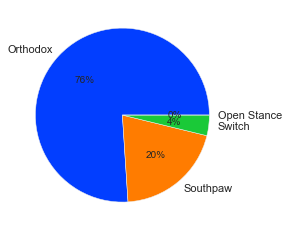

In [153]:
colors = sns.color_palette('bright')[0:5]
plt.figsize = (20,15)
plt.pie(df['stance'].value_counts(), colors=colors,
        labels = ['Orthodox', 'Southpaw', 'Switch', 'Open Stance'],  autopct='%.0f%%')
plt.show()

In [154]:
df['SLpM'].corr(df['tko_win_ratio'], method='spearman') 

0.2226215331864061

##### Let's use spearman correlation (normality) to see which numerical columns are more correlated to on another 

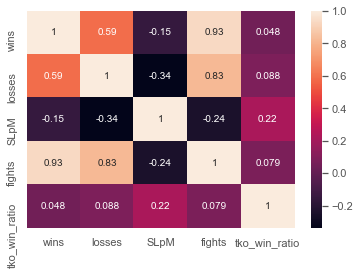

In [155]:
#We see that tko_win_ratio has the biggest positive correlation with SLpM
plt.figsize = (20,25)
sns.heatmap(df.corr(method='spearman'), annot=True)
plt.show()

In [156]:
#No missing values
df[df.isna().any(axis=1)]

,name,last_name,stance,wins,losses,SLpM,fights,tko_win_ratio


In [157]:
#Checking the mean and number of samples per stance cat
df.groupby('stance')['tko_win_ratio'].agg(['count', 'mean', 'std', 'median']) 

,count,mean,std,median
stance,,,,
Open Stance,0,NaN,NaN,NaN
Orthodox,479,0.342041,0.239185,0.330078
Southpaw,127,0.325439,0.254465,0.310059
Switch,24,0.385742,0.269499,0.415039


In [158]:
'''The samples may be few, but we're conducting tests
only on the fighters that have sufficient UFC (not overall career)
experience'''

print(f'''Number of rows left: {df.shape[0]}''')

Number of rows left: 630


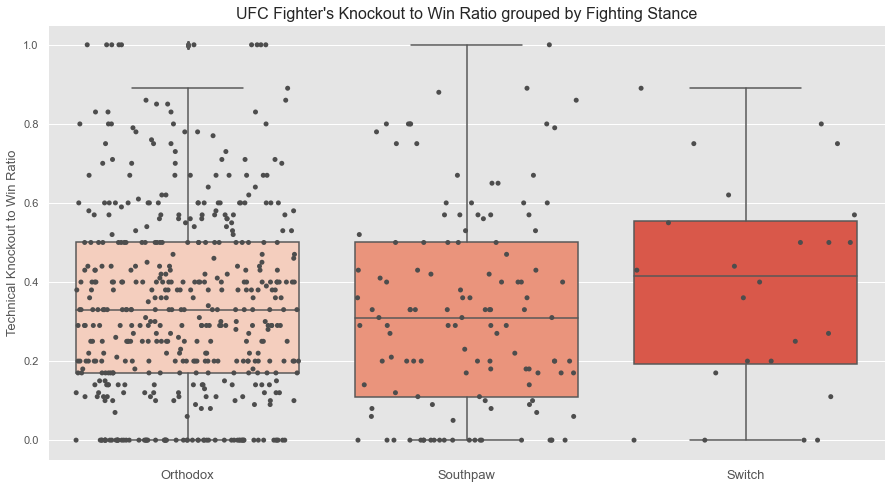

In [159]:
#Visualizing the mean comparison
#But this is not conclusive
plt.figure(figsize=(15,8))
sns.set_palette("Reds", 4)
sns.boxplot(x="stance",y="tko_win_ratio",data=df,order=["Orthodox", "Southpaw", "Switch"])
sns.stripplot(x="stance", y="tko_win_ratio", data=df, order=["Orthodox", "Southpaw", "Switch"], jitter=0.4, color="0.3")
plt.title("UFC Fighter's Knockout to Win Ratio grouped by Fighting Stance", fontsize=16)
plt.xlabel("")
plt.xticks([0,1,2],["Orthodox","Southpaw","Switch"],fontsize=13)
plt.ylabel("Technical Knockout to Win Ratio", fontsize=13)

#Save to downloads folder
plt.savefig("stance_tko-ratio-boxplot.png")

plt.show()

In [160]:
'''We've got fighters here who've fought numerous times but have 0 SLpM.
I've found out that these particular fighters have very few fights in the UFC itself (via the site),
excluding the prelims. So, these fighters are excluded from the tests'''

df = df[df['SLpM']!=0]

### Checking the assumptions and conducting ANOVA 

##### 1. Normality of the categories 

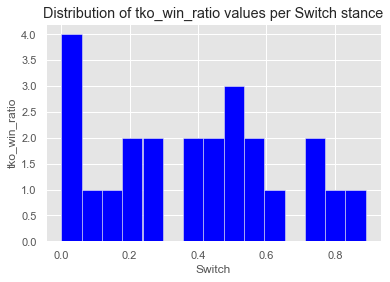

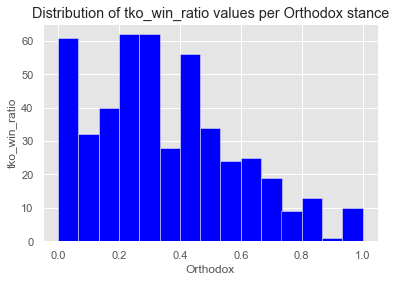

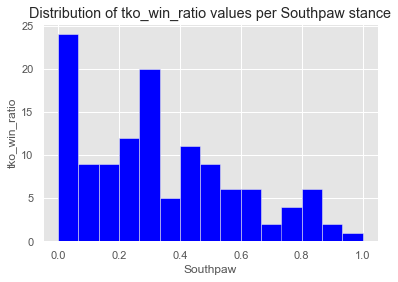

In [161]:
#They're all mount-shaped, however, we notice quite a few outliers
for f in df['stance'].unique():
    plt.hist(df[df['stance']==f]['tko_win_ratio'], color='blue', bins=15)
    plt.title(f'Distribution of tko_win_ratio values per {f} stance')
    plt.xlabel(f)
    plt.ylabel('tko_win_ratio')
    plt.savefig('Stance_tko_normality.png')
    plt.show()

In [162]:
'''Conducting Kolgorov-Smirnov test. 2 stance's p-values are below 0.05 which
doesn't suggest normal distribution, however, this test is sensitive
to outliers and we're looking for enough normality to conduct ANOVA'''
for f in df['stance'].unique():
    normality_test = kstest_normal(df[df['stance']==f]['tko_win_ratio'])
    print(f'''P value for {f} category: {normality_test[1]}''') 

P value for Switch category: 0.8746371809364659
P value for Orthodox category: 0.0009999999999998899
P value for Southpaw category: 0.006740387567031209


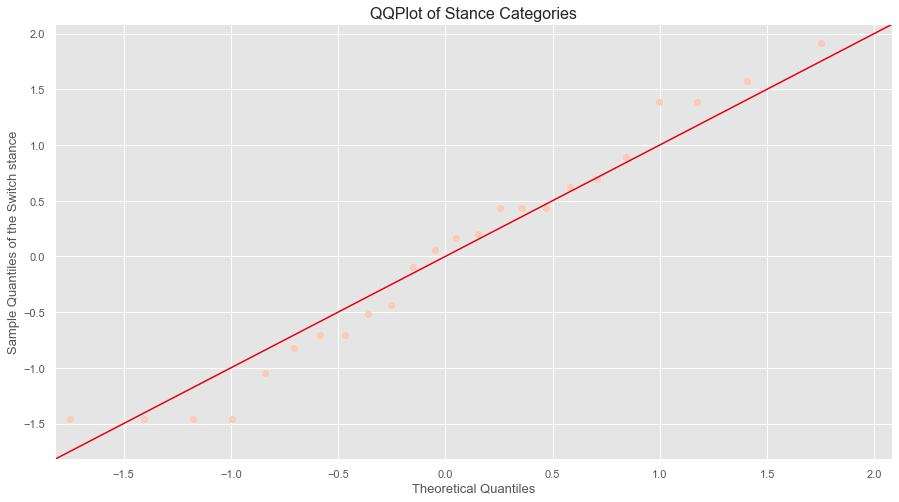

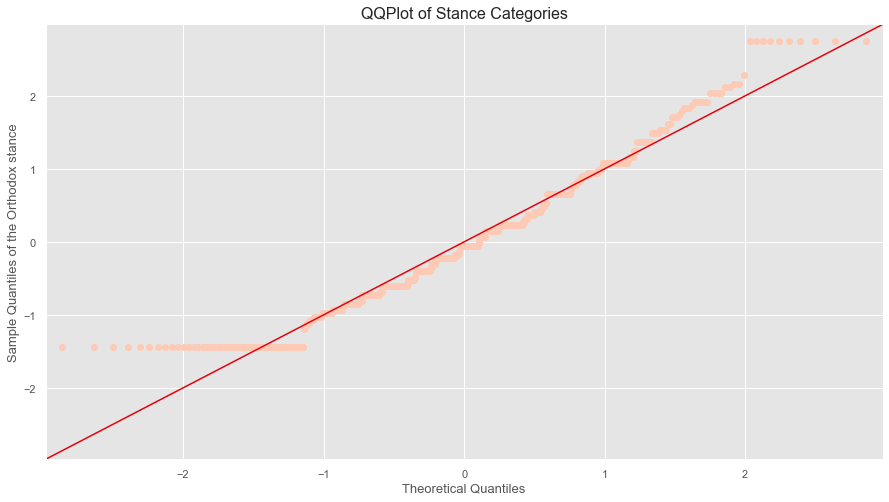

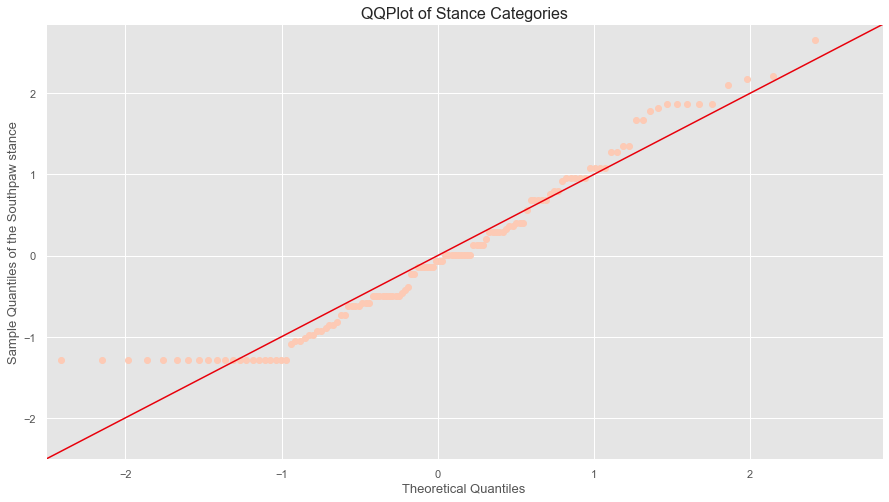

In [163]:
#Let's check theoretical vs actual quantiles and see how much they differ
for f in df['stance'].unique():
    fig = qqplot(df[df['stance']==f]['tko_win_ratio'], line = '45', fit=True)
    ax = plt.gca()
    fig.set_size_inches(15, 8)
    ax.set_xlabel('Theoretical Quantiles', fontsize=13)
    ax.set_ylabel(f'Sample Quantiles of the {f} stance', fontsize=13)
    ax.set_title("QQPlot of Stance Categories", fontsize=16)
plt.show()
#They look even enough

In [164]:
#Now let's conduct Shapiro-Wilk test for more confident results
for f in df['stance'].unique():
    print(f'''P-value for {f} stance: {shapiro(df[df['stance']==f]['tko_win_ratio']).pvalue}''')
#They're all above 0.05. We may reject the null hypothesis    

P-value for Switch stance: 0.29995888471603394
P-value for Orthodox stance: 2.4719229441139134e-10
P-value for Southpaw stance: 3.15619763568975e-05


##### 2. Residual sum zero

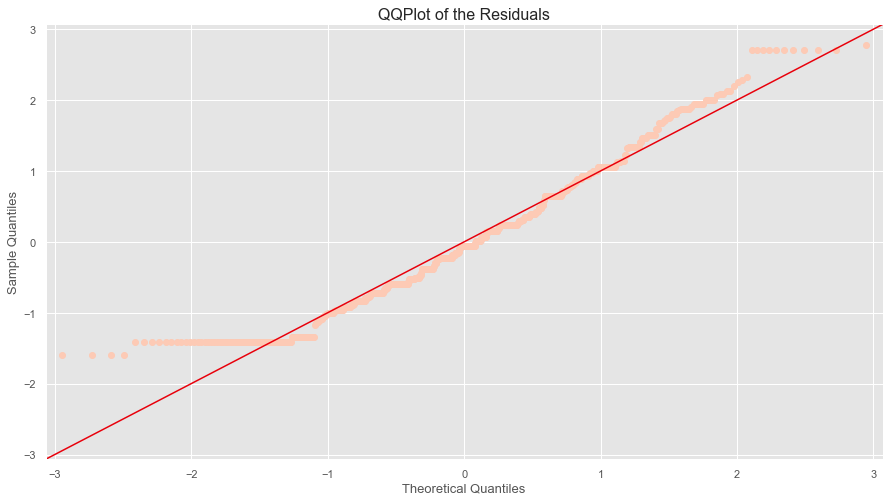

In [165]:
#It's considered fairly on the linear line. We've opted to be a bit less rigid here
stance = ols("tko_win_ratio ~ C(stance)", data = df).fit()
residuals = stance.resid

fig = qqplot(residuals, line = '45', fit=True)

ax = plt.gca()
fig.set_size_inches(15, 8)
ax.set_xlabel("Theoretical Quantiles", fontsize=13)
ax.set_ylabel("Sample Quantiles", fontsize=13)
ax.set_title("QQPlot of the Residuals", fontsize=16)
plt.savefig('Residuals_stance_tko.png')
plt.show()

##### 3. Equal variance 

In [166]:
'''Standard deviation seem pretty close. Let's
make sure with Levene test'''

df.groupby('stance')['tko_win_ratio'].describe()['std'].to_frame() 

,std
stance,
Open Stance,NaN
Orthodox,0.238770
Southpaw,0.254639
Switch,0.269531


In [167]:
#Above 0.05. No null hypothesis
homoscedasticity_test = levene(df[df['stance']=='Orthodox']['tko_win_ratio'], 
                               df[df['stance']=='Southpaw']['tko_win_ratio'],
                              df[df['stance']=='Switch']['tko_win_ratio'])

print(f'''Levene test p-value: {homoscedasticity_test[1]}''')

Levene test p-value: 0.37038170855806174


#### ~Test

In [168]:
'''Although switch fighters have an advantage in
knockout percentage, the test results show that 
there isn't enough evidence to conclude that it
is true. Thus, we're unable to reject the null hypothesis. '''
lm = ols('tko_win_ratio ~ C(stance) ',data=df).fit()
table = anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(stance),3.0,0.081382,0.027127,0.458391,0.711462
Residual,623.0,36.868782,0.059179,NaN,NaN


In [169]:
#Pairwise test display the same
mc = pairwise_tukeyhsd(df['tko_win_ratio'], df['stance'])
result = mc._results_table

print(result)
print(mc.groupsunique)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
Orthodox Southpaw  -0.0166  0.775 -0.0738 0.0407  False
Orthodox   Switch   0.0421 0.6862 -0.0775 0.1617  False
Southpaw   Switch   0.0587 0.5249 -0.0686  0.186  False
-------------------------------------------------------
['Orthodox' 'Southpaw' 'Switch']
